In [1]:
%matplotlib inline

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [11]:
league_data = pd.read_csv("data/results.csv")
stats = pd.read_csv("data/stats.csv")
standings = pd.read_csv("data/EPL Standings 2000-2022.csv")
with_goalscorers = pd.read_csv("data/with_goalscorers.csv")

In [12]:
league_data

,home_team,away_team,home_goals,away_goals,result,season
0,Sheffield United,Liverpool,1.0,1.0,D,2006-2007
1,Arsenal,Aston Villa,1.0,1.0,D,2006-2007
2,Everton,Watford,2.0,1.0,H,2006-2007
3,Newcastle United,Wigan Athletic,2.0,1.0,H,2006-2007
4,Portsmouth,Blackburn Rovers,3.0,0.0,H,2006-2007
...,...,...,...,...,...,...
4555,Newcastle United,Chelsea,3.0,0.0,H,2017-2018
4556,Southampton,Manchester City,0.0,1.0,A,2017-2018
4557,Swansea City,Stoke City,1.0,2.0,A,2017-2018
4558,Tottenham Hotspur,Leicester City,5.0,4.0,H,2017-2018


In [13]:
league_data.dtypes

home_team      object
away_team      object
home_goals    float64
away_goals    float64
result         object
season         object
dtype: object

In [14]:
expected_columns = ["home_team", "away_team", "home_goals", "away_goals", "result", "season"]
expected_shape=(4560,6)

In [15]:
new_standings = standings[standings['Season'].between('2006-07','2017-18')]

In [16]:
new_standings[new_standings.Pos == 1]

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
120,2006-07,1,Manchester United,38,28,5,5,83,27,56,89,Qualification for the Champions League group s...
140,2007-08,1,Manchester United,38,27,6,5,80,22,58,87,Qualification for the Champions League group s...
160,2008-09,1,Manchester United,38,28,6,4,68,24,44,90,Qualification for the Champions League group s...
180,2009-10,1,Chelsea,38,27,5,6,103,32,71,86,Qualification for the Champions League group s...
200,2010-11,1,Manchester United,38,23,11,4,78,37,41,80,Qualification for the Champions League group s...
220,2011-12,1,Manchester City,38,28,5,5,93,29,64,89,Qualification for the Champions League group s...
240,2012-13,1,Manchester United,38,28,5,5,86,43,43,89,Qualification for the Champions League group s...
260,2013-14,1,Manchester City,38,27,5,6,102,37,65,86,Qualification for the Champions League group s...
280,2014-15,1,Chelsea,38,26,9,3,73,32,41,87,Qualification for the Champions League group s...
300,2015-16,1,Leicester City,38,23,12,3,68,36,32,81,Qualification for the Champions League group s...


In [17]:
new_standings.dtypes

Season                         object
Pos                             int64
Team                           object
Pld                             int64
W                               int64
D                               int64
L                               int64
GF                              int64
GA                              int64
GD                              int64
Pts                             int64
Qualification or relegation    object
dtype: object

In [18]:
new_standings.reset_index(drop=True, inplace=True)

In [19]:
new_standings = new_standings.drop("Qualification or relegation", axis=1)

In [20]:
new_standings

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,2006-07,1,Manchester United,38,28,5,5,83,27,56,89
1,2006-07,2,Chelsea,38,24,11,3,64,24,40,83
2,2006-07,3,Liverpool,38,20,8,10,57,27,30,68
3,2006-07,4,Arsenal,38,19,11,8,63,35,28,68
4,2006-07,5,Tottenham Hotspur,38,17,9,12,57,54,3,60
...,...,...,...,...,...,...,...,...,...,...,...
235,2017-18,16,Huddersfield Town,38,9,10,19,28,58,-30,37
236,2017-18,17,Southampton,38,7,15,16,37,56,-19,36
237,2017-18,18,Swansea City,38,8,9,21,28,56,-28,33
238,2017-18,19,Stoke City,38,7,12,19,35,68,-33,33


In [21]:
with_goalscorers

,Season,Competition Name,# Squads,Champion,Top Scorer
0,2022-2023,Premier League,20,NaN,Rodrigo - 3(Leeds United)
1,2021-2022,Premier League,20,Manchester City,Son Heung-min Mohamed Salah - 23(Tottenham Hot...
2,2020-2021,Premier League,20,Manchester City,Harry Kane - 23(Tottenham Hotspur)
3,2019-2020,Premier League,20,Liverpool,Jamie Vardy - 23(Leicester City)
4,2018-2019,Premier League,20,Manchester City,Pierre-Emerick Aubameyang Sadio Mané... - 22(A...
5,2017-2018,Premier League,20,Manchester City,Mohamed Salah - 32(Liverpool)
6,2016-2017,Premier League,20,Chelsea,Harry Kane - 29(Tottenham)
7,2015-2016,Premier League,20,Leicester City,Harry Kane - 25(Tottenham)
8,2014-2015,Premier League,20,Chelsea,Sergio Agüero - 26(Manchester City)
9,2013-2014,Premier League,20,Manchester City,Luis Suárez - 31(Liverpool)


In [22]:
with_goalscorers[['Top Scorer Goals', 'Top Scorer Team']] = with_goalscorers['Top Scorer'].str.extract(r'(\d+)\((.*?)\)$')
with_goalscorers.drop('Top Scorer', axis=1, inplace=True)

In [23]:
with_goalscorers

,Season,Competition Name,# Squads,Champion,Top Scorer Goals,Top Scorer Team
0,2022-2023,Premier League,20,NaN,3,Leeds United
1,2021-2022,Premier League,20,Manchester City,23,Tottenham Hotspur Liverpool
2,2020-2021,Premier League,20,Manchester City,23,Tottenham Hotspur
3,2019-2020,Premier League,20,Liverpool,23,Leicester City
4,2018-2019,Premier League,20,Manchester City,22,Arsenal Liverpool
5,2017-2018,Premier League,20,Manchester City,32,Liverpool
6,2016-2017,Premier League,20,Chelsea,29,Tottenham
7,2015-2016,Premier League,20,Leicester City,25,Tottenham
8,2014-2015,Premier League,20,Chelsea,26,Manchester City
9,2013-2014,Premier League,20,Manchester City,31,Liverpool


In [24]:
with_goalscorers.dtypes

Season              object
Competition Name    object
# Squads             int64
Champion            object
Top Scorer Goals    object
Top Scorer Team     object
dtype: object

In [25]:
with_goalscorers["Top Scorer Goals"] = with_goalscorers["Top Scorer Goals"].astype(int)

In [26]:
with_goalscorers.dtypes

Season              object
Competition Name    object
# Squads             int64
Champion            object
Top Scorer Goals     int64
Top Scorer Team     object
dtype: object

In [27]:
with_goalscorers.drop("# Squads", axis=1, inplace = True)

In [28]:
with_goalscorers

,Season,Competition Name,Champion,Top Scorer Goals,Top Scorer Team
0,2022-2023,Premier League,NaN,3,Leeds United
1,2021-2022,Premier League,Manchester City,23,Tottenham Hotspur Liverpool
2,2020-2021,Premier League,Manchester City,23,Tottenham Hotspur
3,2019-2020,Premier League,Liverpool,23,Leicester City
4,2018-2019,Premier League,Manchester City,22,Arsenal Liverpool
5,2017-2018,Premier League,Manchester City,32,Liverpool
6,2016-2017,Premier League,Chelsea,29,Tottenham
7,2015-2016,Premier League,Leicester City,25,Tottenham
8,2014-2015,Premier League,Chelsea,26,Manchester City
9,2013-2014,Premier League,Manchester City,31,Liverpool


In [29]:
with_goalscorers_sorted = with_goalscorers[with_goalscorers.Season.between('2006-2007','2017-2018')]

In [30]:
#STATS DATASET

In [31]:
stats.isna().any()

team                    False
wins                    False
losses                  False
goals                   False
total_yel_card          False
total_red_card          False
total_scoring_att       False
ontarget_scoring_att    False
hit_woodwork            False
att_hd_goal             False
att_pen_goal            False
att_freekick_goal       False
att_ibox_goal           False
att_obox_goal           False
goal_fastbreak          False
total_offside           False
clean_sheet             False
goals_conceded          False
saves                    True
outfielder_block        False
interception            False
total_tackle            False
last_man_tackle         False
total_clearance         False
head_clearance           True
own_goals               False
penalty_conceded        False
pen_goals_conceded      False
total_pass              False
total_through_ball       True
total_long_balls        False
backward_pass            True
total_cross             False
corner_tak

In [33]:
stats[stats.dispossessed.isna()]

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,total_cross,corner_taken,touches,big_chance_missed,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches,season
0,Manchester United,28.0,5.0,83.0,60.0,1.0,698.0,256.0,21.0,12.0,...,918.0,258.0,25686.0,NaN,1.0,NaN,2.0,37.0,25.0,2006-2007
1,Chelsea,24.0,3.0,64.0,62.0,4.0,636.0,216.0,14.0,16.0,...,897.0,231.0,24010.0,NaN,2.0,NaN,1.0,74.0,22.0,2006-2007
2,Liverpool,20.0,10.0,57.0,44.0,0.0,668.0,214.0,15.0,8.0,...,1107.0,282.0,24150.0,NaN,1.0,NaN,0.0,51.0,27.0,2006-2007
3,Arsenal,19.0,8.0,63.0,59.0,3.0,638.0,226.0,19.0,10.0,...,873.0,278.0,25592.0,NaN,1.0,NaN,0.0,88.0,27.0,2006-2007
4,Tottenham Hotspur,17.0,12.0,57.0,48.0,3.0,520.0,184.0,6.0,5.0,...,796.0,181.0,22200.0,NaN,2.0,NaN,0.0,51.0,24.0,2006-2007
5,Bolton Wanderers,16.0,14.0,47.0,84.0,4.0,404.0,120.0,7.0,10.0,...,942.0,217.0,18932.0,NaN,6.0,NaN,2.0,44.0,21.0,2006-2007
6,Reading,16.0,15.0,52.0,38.0,3.0,419.0,132.0,8.0,15.0,...,1067.0,280.0,18017.0,NaN,2.0,NaN,0.0,63.0,21.0,2006-2007
7,Blackburn Rovers,15.0,16.0,52.0,77.0,6.0,478.0,155.0,5.0,12.0,...,911.0,205.0,20812.0,NaN,8.0,NaN,5.0,56.0,25.0,2006-2007
8,Everton,15.0,10.0,52.0,65.0,2.0,465.0,153.0,9.0,9.0,...,867.0,208.0,19250.0,NaN,2.0,NaN,1.0,83.0,15.0,2006-2007
9,Portsmouth,14.0,12.0,45.0,48.0,1.0,525.0,186.0,9.0,13.0,...,783.0,247.0,19377.0,NaN,4.0,NaN,2.0,79.0,30.0,2006-2007


In [36]:
stats.drop(["saves", "head_clearance", "total_through_ball", "backward_pass","big_chance_missed"], axis=1, inplace=True)
stats

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,total_long_balls,total_cross,corner_taken,touches,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches,season
0,Manchester United,28.0,5.0,83.0,60.0,1.0,698.0,256.0,21.0,12.0,...,2397.0,918.0,258.0,25686.0,1.0,NaN,2.0,37.0,25.0,2006-2007
1,Chelsea,24.0,3.0,64.0,62.0,4.0,636.0,216.0,14.0,16.0,...,2270.0,897.0,231.0,24010.0,2.0,NaN,1.0,74.0,22.0,2006-2007
2,Liverpool,20.0,10.0,57.0,44.0,0.0,668.0,214.0,15.0,8.0,...,2800.0,1107.0,282.0,24150.0,1.0,NaN,0.0,51.0,27.0,2006-2007
3,Arsenal,19.0,8.0,63.0,59.0,3.0,638.0,226.0,19.0,10.0,...,2045.0,873.0,278.0,25592.0,1.0,NaN,0.0,88.0,27.0,2006-2007
4,Tottenham Hotspur,17.0,12.0,57.0,48.0,3.0,520.0,184.0,6.0,5.0,...,2408.0,796.0,181.0,22200.0,2.0,NaN,0.0,51.0,24.0,2006-2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Huddersfield Town,9.0,19.0,28.0,62.0,3.0,362.0,109.0,8.0,5.0,...,2563.0,765.0,165.0,22619.0,6.0,416.0,2.0,31.0,24.0,2017-2018
236,Swansea City,8.0,21.0,28.0,51.0,1.0,338.0,103.0,8.0,3.0,...,2580.0,694.0,150.0,22775.0,1.0,439.0,3.0,44.0,15.0,2017-2018
237,Southampton,7.0,16.0,37.0,63.0,2.0,450.0,145.0,15.0,7.0,...,2541.0,800.0,227.0,24639.0,4.0,379.0,1.0,29.0,13.0,2017-2018
238,Stoke City,7.0,19.0,35.0,62.0,1.0,384.0,132.0,8.0,8.0,...,2528.0,598.0,136.0,20368.0,3.0,402.0,0.0,27.0,14.0,2017-2018


In [37]:
league_data.isna().any()

home_team     False
away_team     False
home_goals    False
away_goals    False
result        False
season        False
dtype: bool

In [46]:
champions = new_standings[new_standings.Pos==1]

In [47]:
champions.reset_index(drop=True, inplace=True)

In [48]:
champions

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,2006-07,1,Manchester United,38,28,5,5,83,27,56,89
1,2007-08,1,Manchester United,38,27,6,5,80,22,58,87
2,2008-09,1,Manchester United,38,28,6,4,68,24,44,90
3,2009-10,1,Chelsea,38,27,5,6,103,32,71,86
4,2010-11,1,Manchester United,38,23,11,4,78,37,41,80
5,2011-12,1,Manchester City,38,28,5,5,93,29,64,89
6,2012-13,1,Manchester United,38,28,5,5,86,43,43,89
7,2013-14,1,Manchester City,38,27,5,6,102,37,65,86
8,2014-15,1,Chelsea,38,26,9,3,73,32,41,87
9,2015-16,1,Leicester City,38,23,12,3,68,36,32,81


In [49]:
#EXPLORATORY DATA ANALYSIS

In [51]:
most_goals_scored = stats.loc[stats.goals.idxmax()][['team', 'goals', 'season']]
print(most_goals_scored)

team      Manchester City
goals               106.0
season          2017-2018
Name: 220, dtype: object


In [52]:
#FIRST TEAM TO SCORE MOST GOALS AND NOT BECOME CHAMPIONS

In [53]:
non_champions = new_standings[new_standings['Pos']!=1]
non_champions.reset_index(drop=True, inplace = True)


In [54]:
most_goals_non_champion = non_champions.nlargest(1, 'GF')
print(most_goals_non_champion[['Team','GF','Season','Pts']])

          Team   GF   Season  Pts
133  Liverpool  101  2013-14   84


In [55]:
champions_scored_less_liverpool = champions[champions['GF'] < non_champions['GF'].max()]
champions_scored_less_liverpool.shape[0]

9

In [56]:
champions_scored_more = champions[champions.GF>non_champions.GF.max()]
print(champions_scored_more)

     Season  Pos             Team  Pld   W  D  L   GF  GA  GD  Pts
3   2009-10    1          Chelsea   38  27  5  6  103  32  71   86
7   2013-14    1  Manchester City   38  27  5  6  102  37  65   86
11  2017-18    1  Manchester City   38  32  4  2  106  27  79  100


In [57]:


#LIVERPOOL"S CASE DETERMINES THAT SCORING GOALS ONLY DOESN'T WIN THE LEAGUE.



In [58]:
with_goalscorers_sorted = with_goalscorers.copy() # To avoid a warning
with_goalscorers_sorted.sort_values(by='Season', inplace=True)
with_goalscorers_sorted.reset_index(drop=True, inplace=True)

In [60]:
with_goalscorers_sorted

,Season,Competition Name,Champion,Top Scorer Goals,Top Scorer Team
0,1992-1993,FA Premier League,Manchester United,22,Tottenham Hotspur
1,1993-1994,FA Premier League,Manchester United,34,Newcastle United
2,1994-1995,FA Premier League,Blackburn Rovers,34,Blackburn Rovers
3,1995-1996,FA Premier League,Manchester United,31,Blackburn Rovers
4,1996-1997,FA Premier League,Manchester United,25,Newcastle United
5,1997-1998,FA Premier League,Arsenal,18,Liverpool Blackburn Rovers
6,1998-1999,FA Premier League,Manchester United,18,Manchester United Chelsea
7,1999-2000,FA Premier League,Manchester United,30,Sunderland
8,2000-2001,FA Premier League,Manchester United,23,Chelsea
9,2001-2002,FA Premier League,Arsenal,24,Arsenal


In [83]:
with_goalscorers_sorted['Champion'] = with_goalscorers_sorted['Champion'].fillna('').astype(str)
with_goalscorers_sorted['Top Scorer Team'] = with_goalscorers_sorted['Top Scorer Team'].fillna('').astype(str)
goalscorer_champions = with_goalscorers_sorted[with_goalscorers_sorted.apply(lambda row: row['Champion'] in row['Top Scorer Team'].split(','), axis=1)]

In [84]:
goalscorer_champions

,Season,Competition Name,Champion,Top Scorer Goals,Top Scorer Team
2,1994-1995,FA Premier League,Blackburn Rovers,34,Blackburn Rovers
9,2001-2002,FA Premier League,Arsenal,24,Arsenal
10,2002-2003,FA Premier League,Manchester United,25,Manchester United
11,2003-2004,FA Premier League,Arsenal,30,Arsenal
15,2007-2008,Premier League,Manchester United,31,Manchester United
17,2009-2010,Premier League,Chelsea,29,Chelsea
20,2012-2013,Premier League,Manchester United,26,Manchester United


In [85]:
percentage_tg_ch = len(goalscorer_champions) / len(with_goalscorers_sorted[14:26]) * 100
percentage_formatted = f"{percentage_tg_ch:.1f}%"
print(percentage_formatted)

58.3%


In [86]:

#MARGIN OF VICTORY FOR EVERY CHAMPION DURING THIS PERIOD

In [88]:
second_placed = new_standings[new_standings.Pos==2]
second_placed.reset_index(drop=True,inplace=True)

In [89]:
third_placed = new_standings[new_standings.Pos==3]
third_placed.reset_index(drop=True,inplace=True)

In [90]:
winning_margin=champions.Pts-second_placed.Pts

In [91]:
champions = champions.assign(Winning_margin=winning_margin.values)
champions

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Winning_margin
0,2006-07,1,Manchester United,38,28,5,5,83,27,56,89,6
1,2007-08,1,Manchester United,38,27,6,5,80,22,58,87,2
2,2008-09,1,Manchester United,38,28,6,4,68,24,44,90,4
3,2009-10,1,Chelsea,38,27,5,6,103,32,71,86,1
4,2010-11,1,Manchester United,38,23,11,4,78,37,41,80,9
5,2011-12,1,Manchester City,38,28,5,5,93,29,64,89,0
6,2012-13,1,Manchester United,38,28,5,5,86,43,43,89,11
7,2013-14,1,Manchester City,38,27,5,6,102,37,65,86,2
8,2014-15,1,Chelsea,38,26,9,3,73,32,41,87,8
9,2015-16,1,Leicester City,38,23,12,3,68,36,32,81,10


In [93]:


#PLOTTING



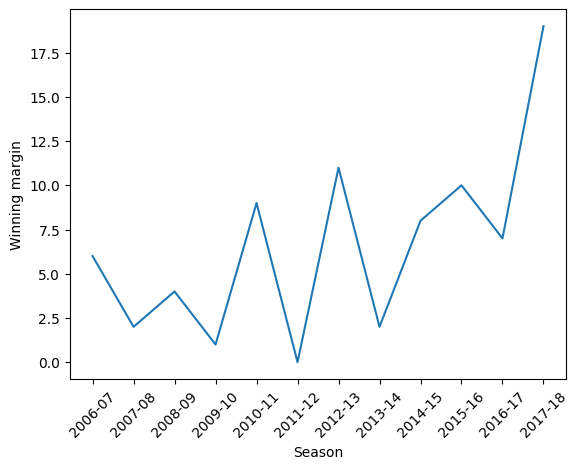

In [94]:
plt.plot(champions.Season,champions.Winning_margin)
plt.xlabel('Season')
plt.ylabel('Winning margin')
plt.xticks(rotation=45)
plt.show()

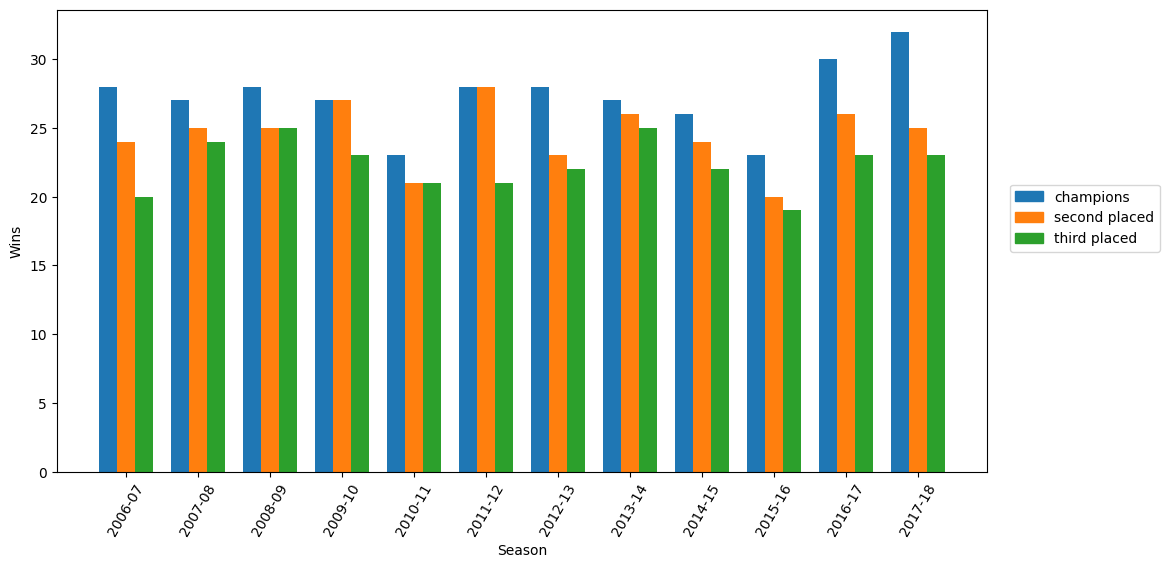

In [95]:
#CREATING A BAR CHART

barWidth=0.25
fig = plt.subplots(figsize =(12, 6))

br1 = np.arange(len(champions.W))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


plt.bar(br1,champions.W,width = barWidth)
plt.bar(br2,second_placed.W,width = barWidth)
plt.bar(br3,third_placed.W,width = barWidth)


plt.xlabel('Season')
plt.ylabel('Wins')
plt.xticks([r + barWidth for r in range(len(champions.W))],
        champions.Season.tolist())
plt.xticks(rotation =60)
colors = {'champions':'tab:blue', 'second placed':'tab:orange', 'third placed':'tab:green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels,bbox_to_anchor=(1.05, 0.6),
           bbox_transform=plt.gcf().transFigure)
plt.show()

In [97]:


#WHICH TEAMS WON THE LEAGUE MOST NUMBER OF TIMES



In [98]:
times_champion = champions.Team.value_counts()
teams = times_champion.index.to_list()

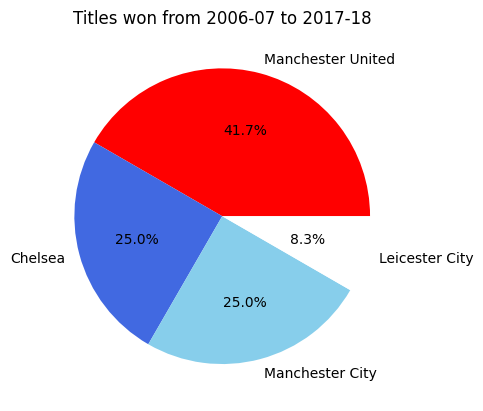

In [99]:
plt.pie(times_champion,
    labels = teams,
    autopct ='%1.1f%%',
    colors = ['red','royalblue','skyblue','white'])
plt.title('Titles won from 2006-07 to 2017-18')
plt.show()

In [107]:
stats = stats.select_dtypes(include=[np.number])
stats.corr()

,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,att_pen_goal,...,total_pass,total_long_balls,total_cross,corner_taken,touches,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches
wins,1.000000,-0.890199,0.899236,-0.211276,-0.084818,0.753944,0.825577,0.512426,0.354752,0.398314,...,0.701707,-0.228135,0.208196,0.702131,0.704645,-0.316998,0.260774,-0.032365,-0.162252,0.007351
losses,-0.890199,1.000000,-0.825820,0.235155,0.116112,-0.710323,-0.775273,-0.490826,-0.373599,-0.379356,...,-0.646837,0.204358,-0.226708,-0.673469,-0.656575,0.293553,-0.273270,0.017236,0.147711,-0.010721
goals,0.899236,-0.825820,1.000000,-0.235392,-0.084373,0.788062,0.882988,0.564536,0.442670,0.492004,...,0.730479,-0.275572,0.216077,0.737691,0.733838,-0.268003,0.269028,-0.000698,-0.222321,0.017450
total_yel_card,-0.211276,0.235155,-0.235392,1.000000,0.033770,-0.253648,-0.265842,-0.128863,-0.089670,-0.095150,...,-0.216048,0.137093,-0.144025,-0.240047,-0.246781,-0.047345,-0.137412,-0.014418,0.094843,-0.073962
total_red_card,-0.084818,0.116112,-0.084373,0.033770,1.000000,-0.028250,-0.094543,-0.127432,-0.014242,0.038967,...,-0.107723,-0.116108,0.020976,-0.090034,-0.067673,0.112337,-0.001112,0.062797,0.037623,0.089275
total_scoring_att,0.753944,-0.710323,0.788062,-0.253648,-0.028250,1.000000,0.938888,0.605026,0.271458,0.353282,...,0.642285,-0.335641,0.363540,0.794554,0.711154,-0.174188,0.424606,-0.003246,-0.101241,0.138381
ontarget_scoring_att,0.825577,-0.775273,0.882988,-0.265842,-0.094543,0.938888,1.000000,0.626005,0.311790,0.395763,...,0.732246,-0.341806,0.257334,0.786692,0.767850,-0.225950,0.373564,-0.005862,-0.166715,0.096687
hit_woodwork,0.512426,-0.490826,0.564536,-0.128863,-0.127432,0.605026,0.626005,1.000000,0.236210,0.191067,...,0.529739,-0.227261,0.170618,0.536658,0.531672,-0.128247,0.162003,0.042172,-0.178729,-0.049829
att_hd_goal,0.354752,-0.373599,0.442670,-0.089670,-0.014242,0.271458,0.311790,0.236210,1.000000,0.132276,...,0.170387,-0.037376,0.299689,0.296625,0.173216,-0.075413,0.108598,0.017676,-0.048019,-0.115129
att_pen_goal,0.398314,-0.379356,0.492004,-0.095150,0.038967,0.353282,0.395763,0.191067,0.132276,1.000000,...,0.233146,-0.105929,0.056393,0.332663,0.244434,-0.094283,0.146317,0.020114,-0.017222,0.127869


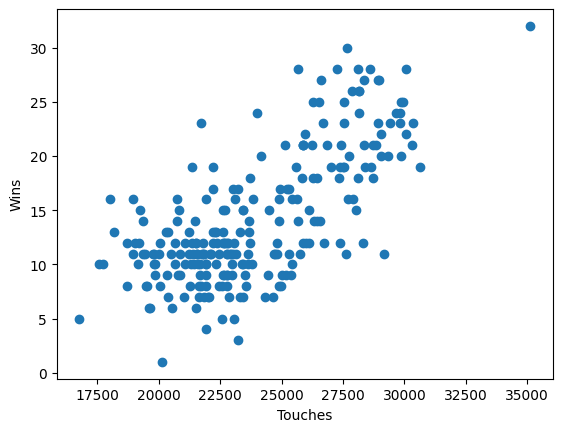

In [108]:
plt.scatter(stats.touches, stats.wins)
plt.xlabel('Touches')
plt.ylabel('Wins')
plt.show()

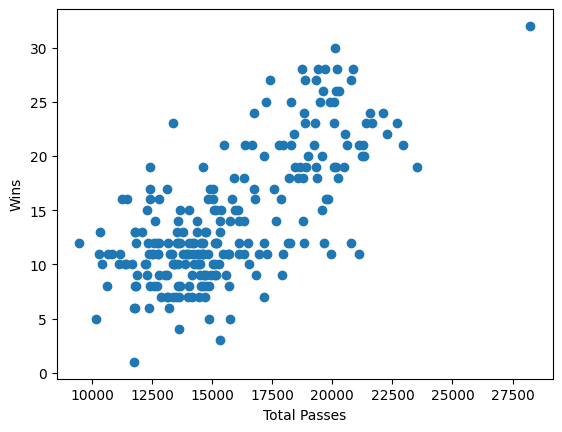

In [110]:
plt.scatter(stats.total_pass, stats.wins)
plt.xlabel('Total Passes')
plt.ylabel('Wins')
plt.show()

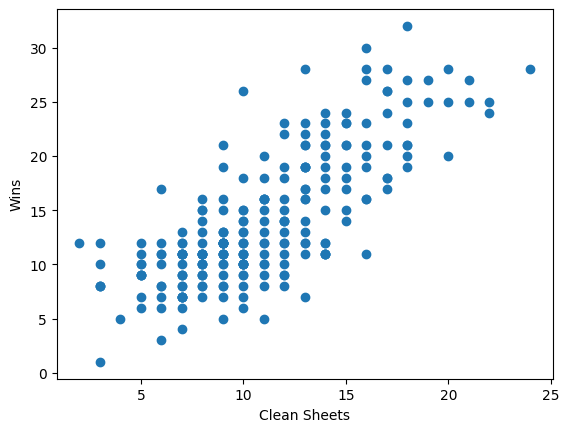

In [111]:
plt.scatter(stats.clean_sheet, stats.wins)
plt.xlabel('Clean Sheets')
plt.ylabel('Wins')
plt.show()

In [112]:
#THESE ARE SOME STRONG POSITIVE RELATIONSHIPS WITH THE USE OF SCATTER PLOT

In [113]:
#MODELLING

In [126]:
y=stats['wins']
X = stats.drop(['wins','dispossessed'],axis = 1)

In [127]:
y.shape

(240,)

In [130]:
X.shape

(240, 33)

In [131]:
#TRAIN TEST SPLIT

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [133]:
regressor = LinearRegression()

In [134]:
regressor.fit(X_train, y_train)

LinearRegression()

In [135]:
y_pred = regressor.predict(X_test)

In [136]:
actual_predicted = pd.DataFrame({'Actual wins': y_test.squeeze(), 'Predicted wins': y_pred.squeeze()}).reset_index(drop=True)
actual_predicted.head()

,Actual wins,Predicted wins
0,19.0,18.945179
1,16.0,14.906297
2,11.0,14.937863
3,13.0,11.139628
4,19.0,16.901664


In [137]:
#NOT EXACTLY ACCURATE. EVALUATING IN FOUR WAYS
# MAE, MSE, RMSE, R squared

In [138]:
#Using sklearn
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [139]:
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 1.50
Mean squared error: 3.09
Root mean squared error: 1.76


In [140]:
regressor.score(X_test, y_test)

0.8568252003050814

In [141]:
#COMPARING ACTUAL VS PREDICTED WINS WITH A PLOT

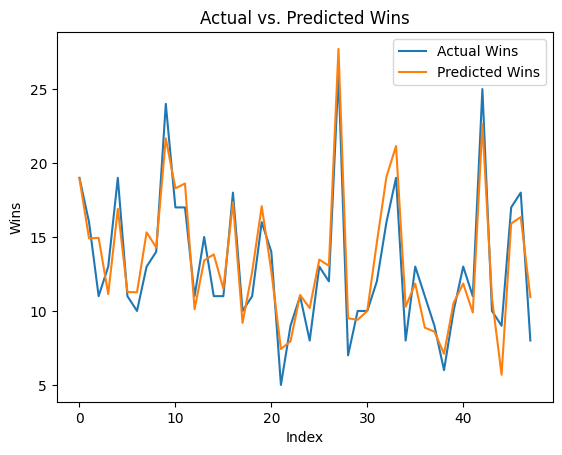

In [142]:
# Create a line plot for actual wins
plt.plot(actual_predicted.index, actual_predicted['Actual wins'], label='Actual Wins')

# Create a line plot for predicted wins
plt.plot(actual_predicted.index, actual_predicted['Predicted wins'], label='Predicted Wins')

plt.xlabel('Index')
plt.ylabel('Wins')
plt.title('Actual vs. Predicted Wins')
plt.legend()
plt.show()

In [143]:
#PLOTTING A CLASSIC LINEAR REGRESSION PLOT, the line plot

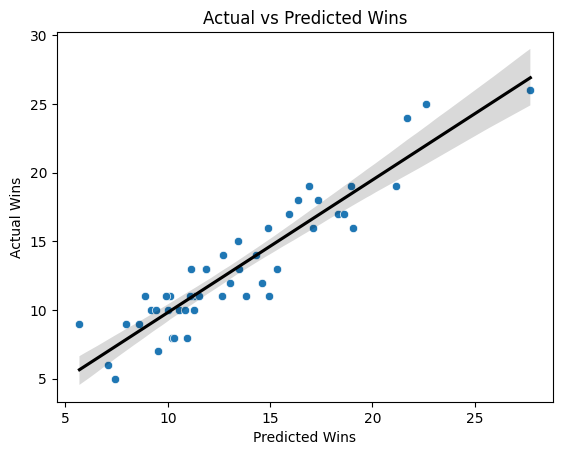

In [147]:
import seaborn as sns
sns.scatterplot(x='Predicted wins', y='Actual wins', data=actual_predicted)
#adding the regression line
sns.regplot(x='Predicted wins', y='Actual wins', data=actual_predicted, scatter=False, color='black')

#Setting axis labels and title
plt.xlabel('Predicted Wins')
plt.ylabel('Actual Wins')
plt.title('Actual vs Predicted Wins')
plt.show()



In [148]:
feature_importance = pd.Series(regressor.coef_, index=X.columns).sort_values(ascending=False)
feature_importance

goals                   1.150184
clean_sheet             0.228201
total_red_card          0.197538
pen_goals_conceded      0.141697
penalty_save            0.111185
att_freekick_goal       0.062252
ontarget_scoring_att    0.019642
clearance_off_line      0.017035
punches                 0.014700
total_yel_card          0.014318
last_man_tackle         0.003645
total_cross             0.000488
total_long_balls        0.000410
total_high_claim        0.000282
total_clearance         0.000198
touches                 0.000166
total_pass             -0.000248
interception           -0.002759
total_tackle           -0.003092
total_scoring_att      -0.004386
corner_taken           -0.007900
outfielder_block       -0.008276
total_offside          -0.010143
hit_woodwork           -0.013100
goal_fastbreak         -0.016428
att_hd_goal            -0.048575
own_goals              -0.048848
losses                 -0.104538
goals_conceded         -0.109290
att_pen_goal           -0.117838
penalty_co